In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from IPython.display import Audio
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier




In [2]:
dataset = pd.read_csv("dataset/features_3_sec.csv")
dataset = dataset.drop(labels="filename", axis=1)

In [3]:
audio = "dataset/genres_original/classical/classical.00035.wav"
data, sr = librosa.load(audio)
Audio(data, rate=sr)

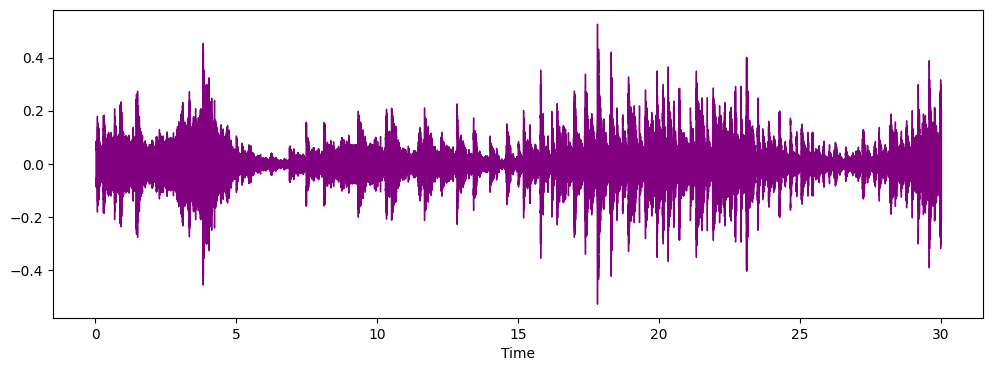

In [4]:
# Plot audio as time series

plt.figure(figsize=(12,4))
librosa.display.waveshow(data, color = "Purple")
plt.show()

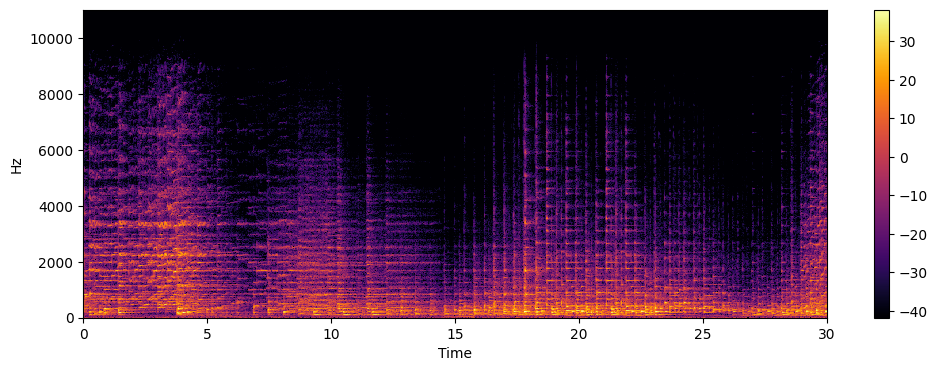

In [5]:
# Convert audio to spectrogram

stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz', cmap="inferno")
plt.colorbar()
plt.show()


In [6]:
# Get classes and encode these to numerical values (0 to 9)

class_list = dataset.iloc[:, -1]
convertor = LabelEncoder()
y = convertor.fit_transform(class_list)


In [7]:
# Get all data except label and standardize features

fit = StandardScaler()
X = fit.fit_transform(np.array(dataset.iloc[:, :-1], dtype = float))

In [8]:
# Split data into train, validation and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
# Train simple XGBClassifier

model_xgboost = XGBClassifier(n_estimators=1000)
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
# Test XGBClassifier

y_pred_train_xgboost = model_xgboost.predict(X_train)
y_pred_test_xgboost = model_xgboost.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train, y_pred_train_xgboost)}')
print(f'Testing accuracy: {accuracy_score(y_test, y_pred_test_xgboost)}')

Training accuracy: 0.9991419991419992
Testing accuracy: 0.8908908908908909


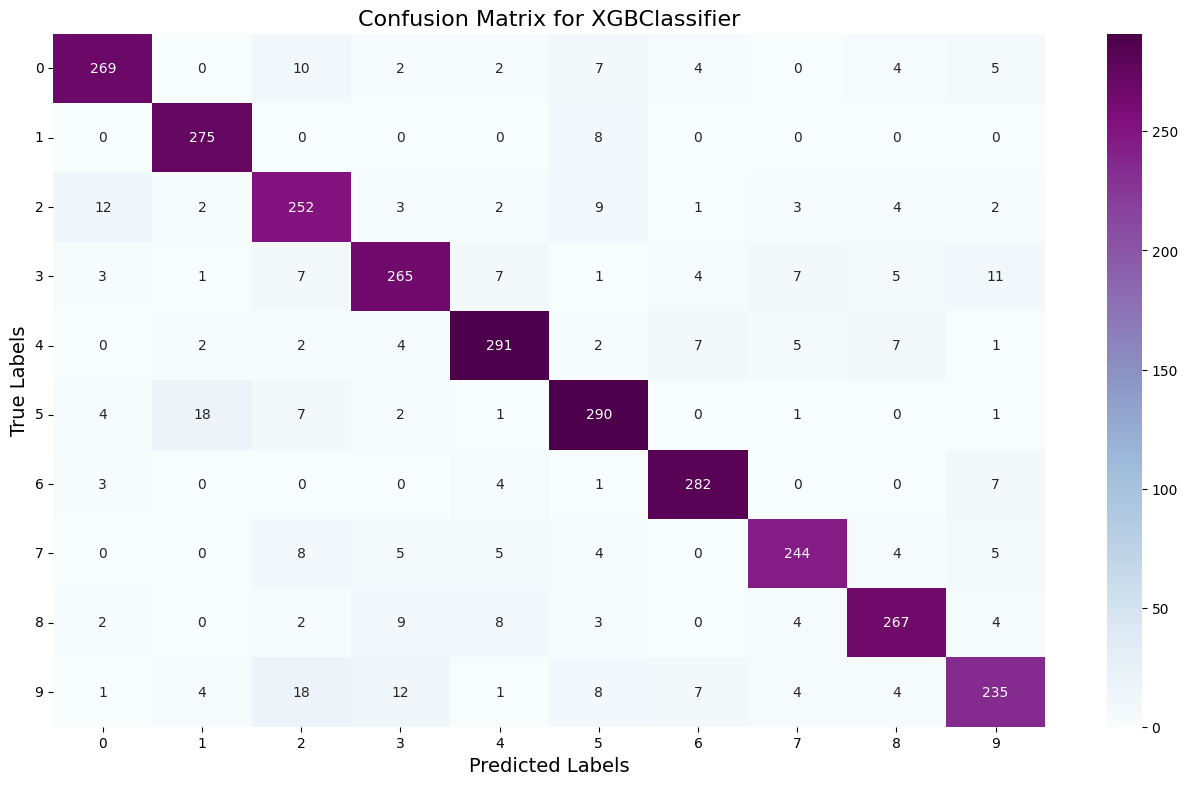

In [23]:
# Confusion Matrix XGBClassifier

con_mat_xgboost = confusion_matrix(y_test, y_pred_test_xgboost)
plt.figure(figsize = (16, 9))
sns.heatmap( con_mat_xgboost, annot=True, fmt="g", cmap="BuPu", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for XGBClassifier", fontsize=16)
plt.xticks()
plt.yticks(rotation=0)
plt.show()

In [66]:
def create_fnn_model(optimizer='adam', dropout_rate='0.2'):
    model_fnn = Sequential([
        Input(shape=(X_train.shape[1],)),
        # Flatten(input_shape=()),
        Dense(512, activation="relu"),
        Dropout(dropout_rate),
        Dense(256, activation="relu"),
        Dropout(dropout_rate),
        Dense(128,activation="relu"),
        Dropout(dropout_rate),
        Dense(64,activation="relu"),
        Dropout(dropout_rate),
        Dense(32,activation="relu"),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    
    model_fnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_fnn


In [69]:
model_fnn = KerasClassifier(model=create_fnn_model, verbose=1, dropout_rate=[0.2, 0.3, 0.4], optimizer=['adam', 'sgd', 'rmsprop'])

param_grid = {
    'batch_size': [32, 64, 128, 256],
    'epochs': [50, 100, 200],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

grid_fnn = GridSearchCV(estimator=model_fnn, param_grid=param_grid, verbose=1, n_jobs=1)

In [ ]:
grid_result_fnn = grid_fnn.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2521 - loss: 2.0052
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5410 - loss: 1.2945
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6588 - loss: 1.0154
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7160 - loss: 0.8691
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7556 - loss: 0.7414
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.6816
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8162 - loss: 0.5928
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8313 - loss: 0.5574
Epoch 9/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8404 - loss: 0.5206
Epoch 10/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8596 - loss: 0.4569
Epoch 11/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - lo

KeyboardInterrupt: 